In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df_raw = pd.read_json('index_set.json', orient='index')

### Preprocessing

In [3]:
# Replace infinite values with NaN, remove outliers
df_pre = df_raw.replace([-np.inf, np.inf], np.nan)
df_pre = df_pre.mask((df_pre < -9998) | (df_pre > 9998))

In [4]:
# Join hail dates
df_hail = pd.read_csv('hail_dates.csv', index_col=0)
df_pre= df_pre.join(df_hail)
df_pre['Hail'] = df_pre['Hail'].replace(np.nan, False)

In [5]:
# Finalize dataframe

# df_pre.drop(df_pre[df_pre['SBLI'] < -10].index, inplace=True)
# df_pre.drop(df_pre[df_pre['SBLI'] > 10].index, inplace=True)
df = df_pre
df

,SBCAPE,SBLCL,SBLFC,SBLI,MUCAPE,MULI,0-1 km SRH,0-1 km Shear,0-3 km SRH,0-6 km Shear,...,EBWD,K-index,SHIP,SCP,STP(cin),STP(fixed),FLCAPE,BRN,LIMAX,Hail
1980-01-01 00:00:00,407.035,445.294,508.208,0.042,407.035,0.042,NaN,22.289,NaN,71.749,...,NaN,26.100,0.072,NaN,NaN,NaN,72.314,3.986,-3.297,False
1980-01-01 12:00:00,276.176,980.924,2519.000,-0.878,276.176,-0.878,NaN,NaN,NaN,NaN,...,NaN,27.778,NaN,NaN,NaN,NaN,0.000,NaN,-1.363,False
1980-01-02 00:00:00,0.000,626.431,NaN,9.800,35.611,9.159,-4.079,6.470,42.221,59.358,...,NaN,18.400,0.000,NaN,NaN,-0.000,0.000,0.000,2.886,False
1980-01-02 12:00:00,32.070,865.863,1046.663,4.833,32.070,4.833,55.493,8.627,232.928,52.800,...,NaN,17.300,0.000,NaN,NaN,0.012,3.719,0.490,-2.087,False
1980-01-03 00:00:00,0.000,310.420,NaN,7.334,0.000,2.396,48.165,7.995,199.238,56.143,...,NaN,25.600,0.000,NaN,NaN,0.000,0.000,0.000,2.254,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-30 00:00:00,0.000,1021.448,NaN,8.057,0.000,4.778,7.762,5.529,60.592,38.870,...,NaN,-12.300,0.000,NaN,NaN,0.000,0.000,0.000,7.921,False
2019-05-30 12:00:00,40.914,2250.135,5156.965,-1.153,40.914,-1.153,-24.157,9.266,3.200,15.692,...,NaN,14.100,0.000,NaN,NaN,-0.000,0.000,66.674,-1.153,False
2019-05-31 00:00:00,0.000,1023.370,NaN,4.106,0.000,0.043,-30.465,10.220,-4.237,18.226,...,NaN,18.300,0.000,NaN,NaN,-0.000,0.000,0.000,8.488,False
2019-05-31 12:00:00,897.338,2134.949,2629.426,-3.327,897.338,-3.327,NaN,11.990,NaN,21.896,...,NaN,18.500,0.152,NaN,NaN,NaN,61.825,99.273,-4.747,False


In [6]:
# Split days based on hail events
df_hail = df.iloc[np.where(df["Hail"])]
df_nonhail = df.iloc[np.where(df["Hail"] == False)]

In [106]:
# Generic criteria class to calculate
# contingency, true skill scores and test scores

class Criteria:
    def __init__(self, name, lower=-1000, upper=1000, a_cond='gt'):
        self.name = name
        self.lower = lower
        self.upper = upper
        self.a_cond = a_cond
        
        
    def contingency(self, threshold):
        if self.a_cond == 'gt':
            hit = len([i for i in self.hail_days if i > threshold])
            false_alarm = len([i for i in self.nonhail_days if i > threshold])
            miss = len([i for i in self.hail_days if i <= threshold])
            correct_negative = len([i for i in self.nonhail_days if i <= threshold])
        else:
            hit = len([i for i in self.hail_days if i < threshold])
            false_alarm = len([i for i in self.nonhail_days if i < threshold])
            miss = len([i for i in self.hail_days if i >= threshold])
            correct_negative = len([i for i in self.nonhail_days if i >= threshold])
        return [hit, false_alarm, miss, correct_negative]
        
    
    def TSS(self, df_hail, df_nonhail, amount=100):
        self.hail_days = df_hail[self.name].values
        self.nonhail_days = df_nonhail[self.name].values
        
        tss_scores = []
        tss_thresholds = []
        space = np.linspace(self.lower, self.upper, amount)
        valid = 0
        for threshold in space:
            try:
                [a, b, c, d] = self.contingency(threshold)
                tss_scores.append(((a/(a+b))-(c/(c+d))))
                tss_thresholds.append(threshold)
                valid += 1
            except:
                pass

        tss_max = max(tss_scores)
        thd_max = tss_thresholds[tss_scores.index(tss_max)]
        
        plt.figure()
        plt.title(self.name)
        plt.xlabel("Threshold")
        plt.ylabel("TSS (True Skill Statistics)")
        
        self.skill_scores(tss_max, thd_max)
        plot_text = "{:10s}{:5f}\n\n".format("Max thd", thd_max) + \
            self.score_table
        plt.text(0.95, 0.05, plot_text, fontsize=14, \
                 fontname='Ubuntu Mono', transform=plt.gcf().transFigure)
        plt.plot(tss_thresholds, tss_scores)
        plt.show()
        
        return [tss_max, thd_max]
    
    
    def skill_scores(self, tss_max, threshold):
        try:
            [a, b, c, d] = self.contingency(threshold)
        except Exception as e:
            print(f"Contingency error in {self.name}: {e}")
            pass

        cha = (a+b)*(a+c)/(a+b+c+d)
        far = (b/(a+b))

        self.scores = {
            "TSS": tss_max,
            "Bias/FBI": (a+b)/(a+c),
            "PC/ACC": (a+d)/(a+b+c+d),
            "POD": a/(a+c),
            "FAR": far,
            "PAG": 1-far,
            "CSI": a/(a+b+c),
            "CSI_X": (a+c)/(a+b+c+d),
            "CHA": cha,
            "HSS": (a-cha)/(a+b-cha),
            "ETS": (a-cha)/(a+b+c-cha),
            "HKS": (a/(a+c))+(d/(b+d))-1,
            "POFD": b/(b+d),
        }
        
        self.score_table = ''
        for key, value in self.scores.items():
            self.score_table = self.score_table + f"{key:10s}{value:5f}\n"

        return self.scores


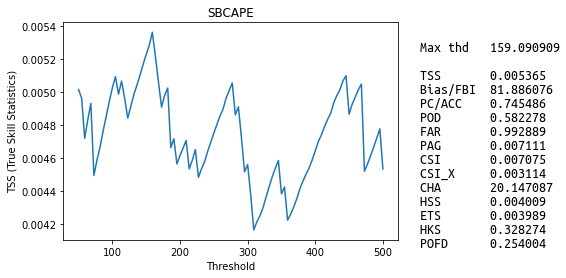

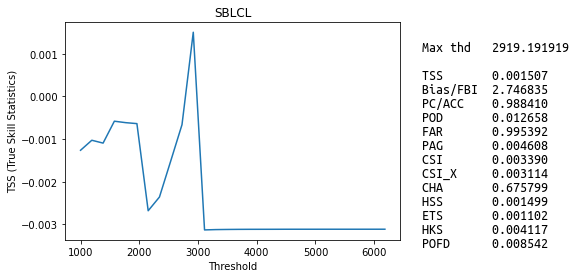

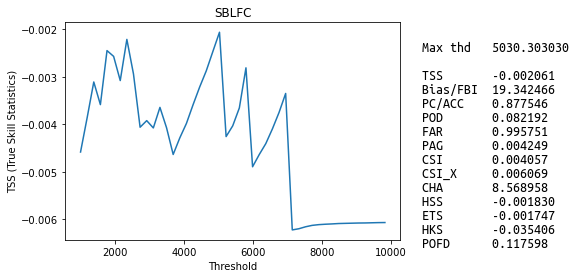

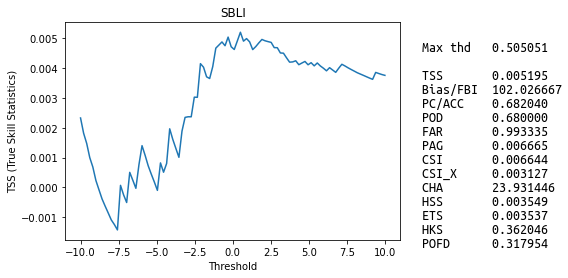

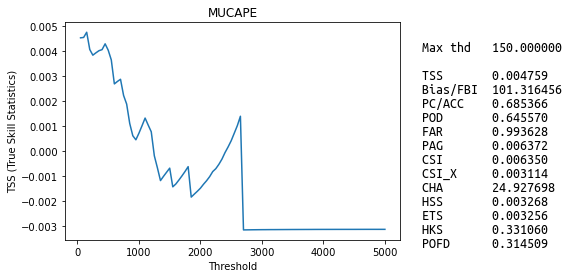

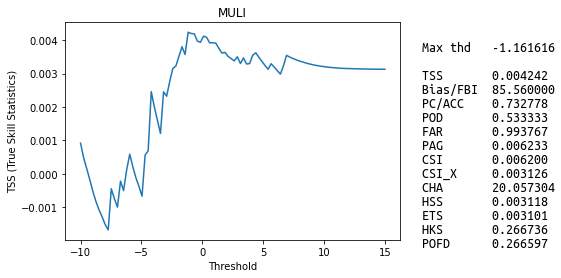

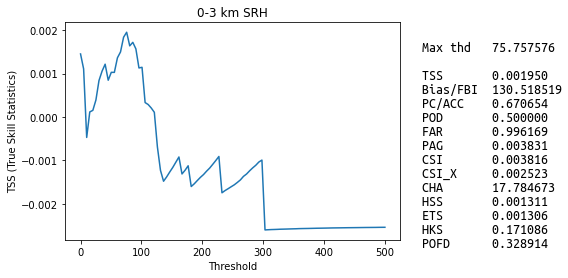

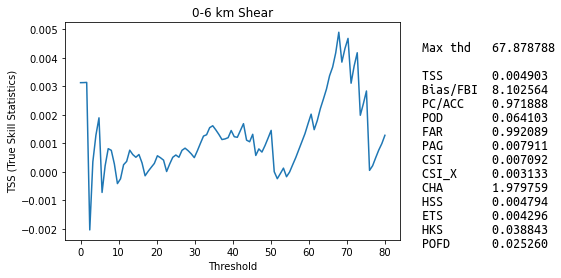

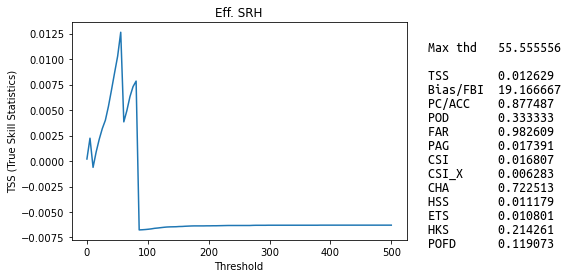

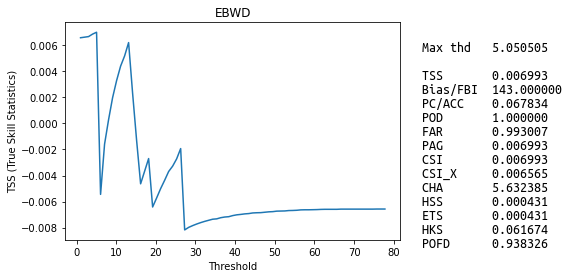

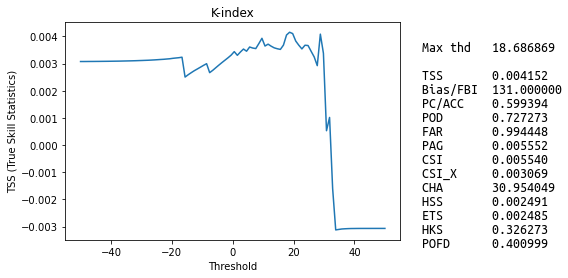

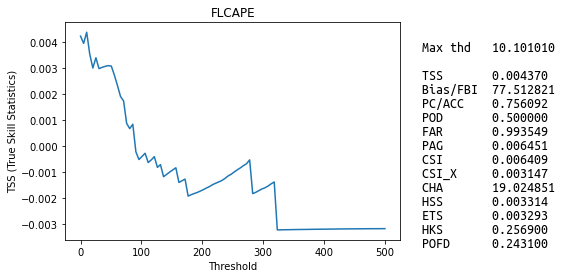

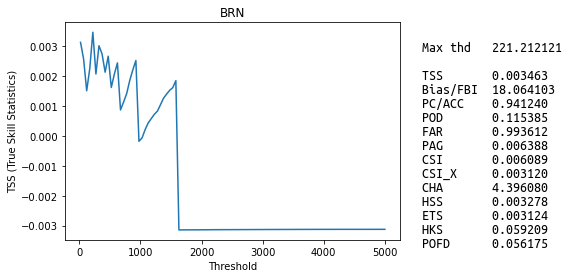

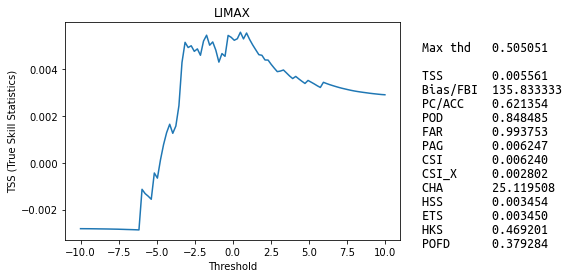

Indices            TSS  Bias/FBI    PC/ACC       POD       FAR       PAG       CSI     CSI_X       CHA       HSS       ETS       HKS      POFD
______________________________________________________________________________________________________________________________________________
SBCAPE           0.005    81.886     0.745     0.582     0.993     0.007     0.007     0.003    20.147     0.004     0.004     0.328     0.254
SBLCL            0.002     2.747     0.988     0.013     0.995     0.005     0.003     0.003     0.676     0.001     0.001     0.004     0.009
SBLFC           -0.002    19.342     0.878     0.082     0.996     0.004     0.004     0.006     8.569    -0.002    -0.002    -0.035     0.118
SBLI             0.005   102.027     0.682     0.680     0.993     0.007     0.007     0.003    23.931     0.004     0.004     0.362     0.318
MUCAPE           0.005   101.316     0.685     0.646     0.994     0.006     0.006     0.003    24.928     0.003     0.003     0.331     0.315

In [107]:
# Test multiple criterion given in an array
# with specific boundary values and contingency conditions

criterion = [
    Criteria("SBCAPE", 50, 500),
    Criteria("SBLCL", 1000, 20000),
    Criteria("SBLFC", 1000, 20000),
    Criteria("SBLI", -10, 10, a_cond='lt'),
    Criteria("MUCAPE", 50, 5000),
    Criteria("MULI", -10, 15, a_cond='lt'),
    #Criteria("0-1 km SRH", -0, 50),
    #Criteria("0-1 km Shear", -500, 500),
    Criteria("0-3 km SRH", -0, 500),
    Criteria("0-6 km Shear", -0, 80),
    Criteria("Eff. SRH", 0, 500),
    Criteria("EBWD", 0, 100),
    Criteria("K-index", -50, 50),
    #Criteria("SHIP", 0, 500),
    #Criteria("SCP", 0, 20000),
    #Criteria("STP(cin)", 0, 5000),
    #Criteria("STP(fixed)", 0, 5000),
    Criteria("FLCAPE", 0, 500),
    Criteria("BRN", 20, 5000),
    Criteria("LIMAX", -10, 10, a_cond='lt'),
]

table_header = ""
table_rows = []
for criteria in criterion:
    try:
        criteria.TSS(df_hail, df_nonhail)
        if not table_header:
            table_header = "{:12s}".format("Indices") + \
                ''.join(list(map(lambda key: f"{key:>10s}",criteria.scores.keys())))
            table_header = table_header + '\n' + '_' * len(table_header)

        table_row = f"{criteria.name:12s}" + \
            ''.join(list(map(lambda value: f"{value:>10.3f}", criteria.scores.values())))
        table_rows.append(table_row)
    except Exception as e:
        print(f"Error with {criteria.name}: {e}")
        
print(table_header)
print(*table_rows, sep='\n')